# Example of light curve

## Introduction
This notebook explain how light curves can be computed with Gammapy. The method implemented follows http://adsabs.harvard.edu/abs/2010A%26A...520A..83H method's. We'll use fake data from the Crab Nebula.

TODO: Check the light curve estimator with good IRFs and real data

## Setup
As usual, we'll start with some setup...

In [1]:
%matplotlib notebook

In [2]:
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.utils.energy import EnergyBounds
from gammapy.data import Target, DataStore
from gammapy.spectrum import SpectrumExtraction
from gammapy.spectrum.models import PowerLaw
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.image import SkyImage
from gammapy.time import LightCurve, LightCurveEstimator

## Extract spectral data
First, we will extract the spectral data needed to build the light curve.

In [3]:
# Prepare the data
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')
obs_ids = [23523, 23526]
obs_list = data_store.obs_list(obs_ids)

# Target definition
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit='deg')
on_region_radius = Angle('0.2 deg')
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
target = Target(on_region=on_region, name='Crab', tag='ana_crab')

# Exclusion regions
exclusion_file = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'
allsky_mask = SkyImage.read(exclusion_file)
exclusion_mask = allsky_mask.cutout(
    position=target.on_region.center,
    size=Angle('6 deg'),
)

# Estimation of the background
bkg_estimator = ReflectedRegionsBackgroundEstimator(on_region=on_region,
                                                    obs_list=obs_list,
                                                    exclusion_mask=exclusion_mask)
bkg_estimator.run()

# Extract the spectral data
e_reco = EnergyBounds.equal_log_spacing(0.7, 100, 50, unit='TeV')  # fine binning
e_true = EnergyBounds.equal_log_spacing(0.05, 100, 200, unit='TeV')
extraction = SpectrumExtraction(obs_list=obs_list,
                                bkg_estimate=bkg_estimator.result,
                                containment_correction=False,
                                e_reco=e_reco,
                                e_true=e_true)
extraction.run()
extraction.compute_energy_threshold(method_lo='area_max', area_percent_lo=10.0)

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.6/site-packages/astropy/units/quantity.py:957: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__truediv__(other)


## Light curve estimation

In [4]:
lc_estimator = LightCurveEstimator(extraction)

# Define the time intervals. Here, we only select intervals corresponding to an observation
intervals = []
for obs in extraction.obs_list:
    intervals.append([obs.events.time[0], obs.events.time[-1]])

# Model to compute the expected counts (generally, parameters come from the fit)
model = PowerLaw(
    index=2. * u.Unit(''),
    amplitude=2.e-11 * u.Unit('1 / (cm2 s TeV)'),
    reference=1 * u.TeV,
)

# Estimation of the light curve
lc = lc_estimator.light_curve(
    time_intervals=intervals,
    spectral_model=model,
    energy_range=[0.7, 100] * u.TeV,
)


## Results
The resulting objects is a table. Attributs can be accessed as follow:

In [5]:
print(lc.colnames)
lc['TIME_MIN', 'TIME_MAX', 'FLUX', 'FLUX_ERR', 'MEASURED_EXCESS', 'EXPECTED_EXCESS']

['TIME_MIN', 'TIME_MAX', 'FLUX', 'FLUX_ERR', 'LIVETIME', 'N_ON', 'N_OFF', 'ALPHA', 'MEASURED_EXCESS', 'EXPECTED_EXCESS']


TIME_MIN,TIME_MAX,FLUX,FLUX_ERR,MEASURED_EXCESS,EXPECTED_EXCESS
,,1 / (cm2 s),1 / (cm2 s),,
object,object,float64,float64,float64,float64
53343.92100685648,53343.94050190008,2.5149099688129456e-11,2.470523510499482e-12,142.833333333,161.134424872
53343.95300319192,53343.972404738815,2.59454633055679e-11,2.5710797800330566e-12,136.666666667,149.445339471


Data can be plot with the buit-in `plot` function

<IPython.core.display.Javascript object>


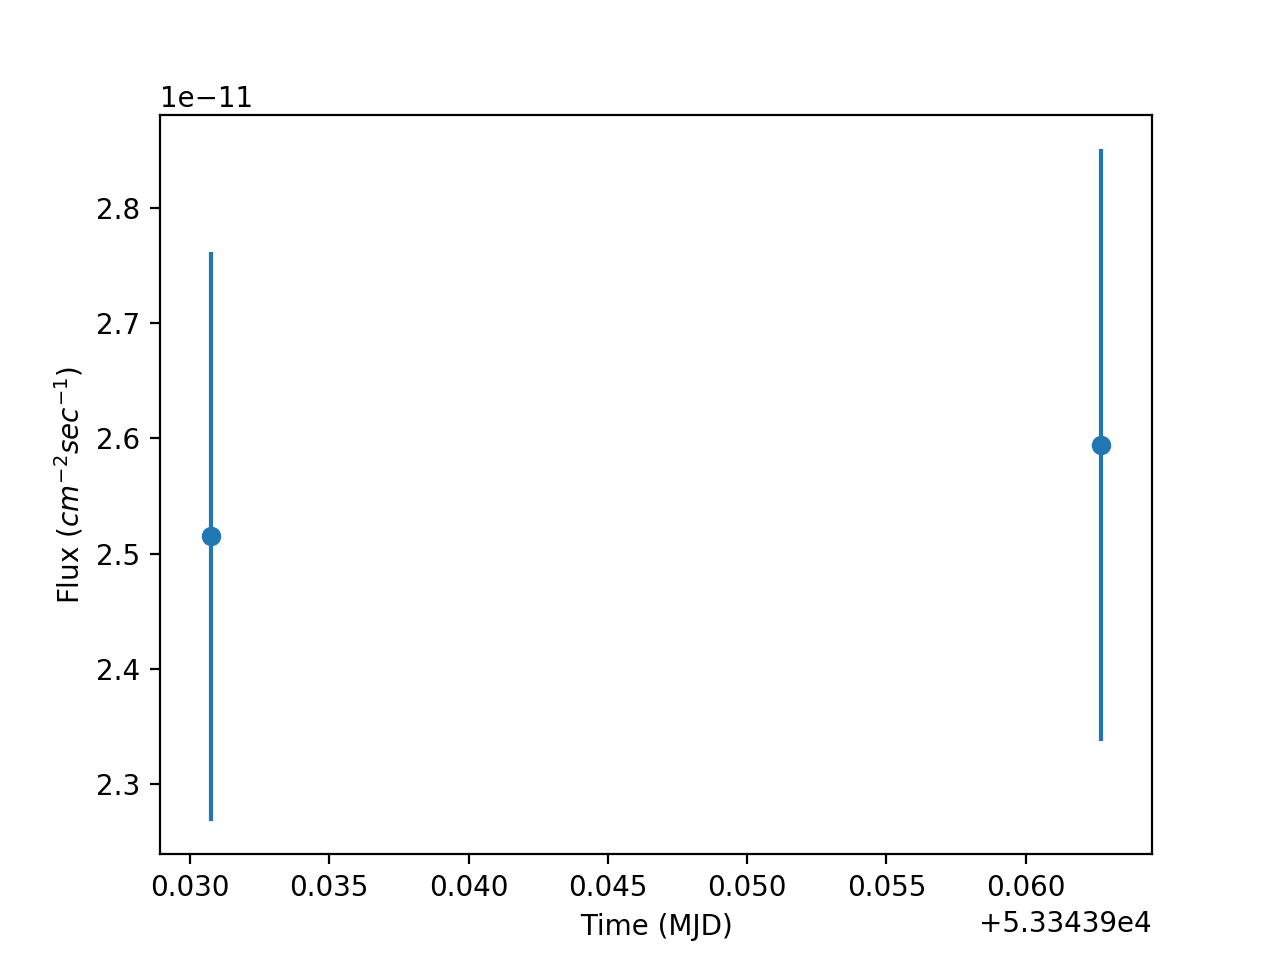

In [6]:
lc.plot()